In [100]:
%matplotlib notebook

%matplotlib inline

import sys

if "." not in sys.path:
    sys.path.insert(0, ".")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##
from sklearn.decomposition import PCA
from openTSNE import TSNE
from bioinfokit.analys import norm
from utils import *

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import black
import jupyter_black

jupyter_black.load(line_length=79)
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("./data")
plt.style.use("../matplotlib_style.txt")

np.random.seed(42)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# 0. Data Loading 

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [101]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [102]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)
data_exons

Count matrix shape (exon):   (1329, 42466)


,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

print("Number of genes:", len(genes))
genes

Number of genes: 42466


array(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', ..., 'n-R5s98',
       'n-TSaga9', 'n-TStga1'], dtype=object)

### Cluster colors

In [104]:
cluster_colors = np.load(data_path / "cluster_colors.npy")
cluster_colors.shape

(1329,)

In [105]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)
rna_type.shape

(1329,)

In [106]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)
len(dict_rna_type_colors)

88

### Electrophysiological features

In [107]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [108]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [109]:
np.sum(np.isnan(ephysData_filtered))

0

# 1. Data Inspection

**Description of the relevant data:**
- exonCounts: 
- exonLengths:
- genes:
- cluster_colors:
- rna_type:
- ephysData_filtered:


In [110]:
# print shapes of relevant data
print("shape of exonCounts: ", exonCounts.shape)
print("shape of exonLengths: ", exonLengths.shape)
print("shape of genes: ", genes.shape)
print("shape of cluster_colors: ", cluster_colors.shape)
print("shape of rna_type: ", rna_type.shape)
print("shape of ephysData: ", ephysData.shape)
# print("shape of ephysData_filtered: ", ephysData_filtered.shape) # emitted because dimensions do not fit to the rest of the data

shape of exonCounts:  (1329, 42466)
shape of exonLengths:  (42466,)
shape of genes:  (42466,)
shape of cluster_colors:  (1329,)
shape of rna_type:  (1329,)
shape of ephysData:  (1329, 29)



We begin by removing all genes that exhibit no expression.

In [111]:
# kick out genes with no expression
keepgenes = np.sum(exonCounts, axis=0) > 0
exonCounts = exonCounts[:, keepgenes]
genes = genes[keepgenes]
exonLengths = exonLengths[keepgenes]

## 1.1 Feature Selection

In accordance with the methodology proposed by Kobak & Berens (2019), we choose features (genes) based on their mean-dropout relationship, as described by Andrews and Hemberg (2018). 

In [112]:
# exclude genes with less than 32 counts in all but 10 cells
cmin = 32
n_cells = np.sum(exonCounts >= cmin, axis=0)
exclude = n_cells < 10

exonCounts_filtered = exonCounts[:, ~exclude]
genes_filtered = genes[~exclude]
exonLengths_filtered = exonLengths[~exclude]

variable_exonLengths = exonLengths[~exclude]

# Calculate Mean Log Non-Zero Expression and Dropout Rate for Each Gene
# dropout rate
d_g = np.mean(exonCounts_filtered <= cmin, axis=0)

# mean log non-zero expression
# write ones for every value that is less than or equal to cmin (log(1) = 0)
exonCounts_filtered[exonCounts_filtered <= cmin] = 1
variable_exonCount_log = np.log2(exonCounts_filtered)
m_g = np.array(
    [
        np.mean(
            variable_exonCount_log[:, i][variable_exonCount_log[:, i] != 0]
        )
        for i in range(variable_exonCount_log.shape[1])
    ]
)
m_g.shape, d_g.shape

((18210,), (18210,))

In [113]:
def boundary(mu, b):
    return np.exp(-1.5 * (mu - b)) + 0.02

In [114]:
# perform binary search to get 500 genes that fullfil the criteria
def binary_search(mu, num_genes):
    """
    Binary search for the optimal value of theta
    """
    alpha_min = 0
    alpha_max = 500
    alpha = (alpha_min + alpha_max) / 2
    i = 0
    while np.sum(d_g > boundary(mu, alpha)) != num_genes and i < 1000:
        if np.sum(d_g > boundary(mu, alpha)) < num_genes:
            alpha_max = alpha
        else:
            alpha_min = alpha
        alpha = (alpha_min + alpha_max) / 2
        # print(alpha)
        i += 1
    return alpha, d_g > boundary(mu, alpha)


offset, idx = binary_search(m_g, 500)

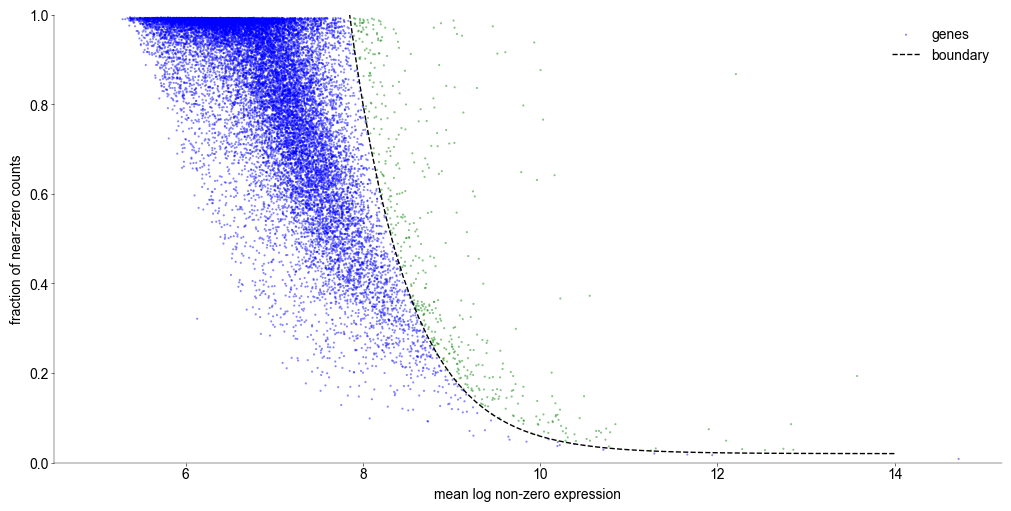

In [115]:
# TODO: make this interactive ?
x = np.linspace(5, 14, 100)

boundary_colors = np.array(["blue", "green"])[
    (d_g > boundary(m_g, offset)).astype(int)
]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(m_g, d_g, s=1, c=boundary_colors, label="genes", alpha=0.5)
ax.set_xlabel("mean log non-zero expression")
ax.set_ylabel("fraction of near-zero counts")
ax.set_ylim(0, 1)
ax.plot(
    x, boundary(x, offset), color="black", linestyle="--", label="boundary"
)

ax.legend()

plt.show()

In [116]:
exonCounts_filtered = exonCounts_filtered[:, idx]
genes_filtered = genes_filtered[idx]
exonLengths_filtered = exonLengths_filtered[idx]

## 1.1. Compute Statistics

Do we want to calculate the statistics of the filtered data or of the exonCounts before manipulating it? 

In [117]:
# Compute the average expression for each gene
avg_expr = np.mean(exonCounts_filtered, axis=0)
frac_zeros = np.mean(exonCounts_filtered == 0, axis=0)

# compute variance
var_expr = np.var(exonCounts_filtered, axis=0)

# Compute fano factor
fano_factor = var_expr / avg_expr

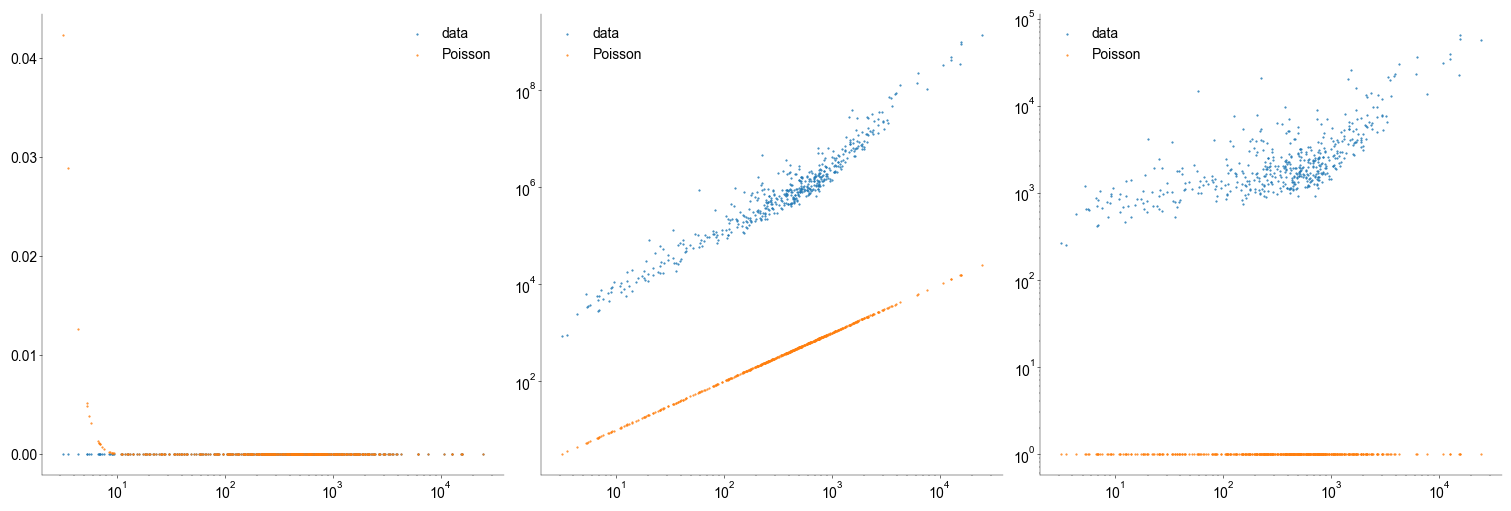

In [118]:
# visualize that the distribution does indeed not follow a poisson distribution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(avg_expr, frac_zeros, s=1, label="data")
axs[0].scatter(avg_expr, np.exp(-avg_expr), s=1, label="Poisson")

axs[1].scatter(avg_expr, var_expr, s=1, label="data")
axs[1].scatter(avg_expr, avg_expr, s=1, label="Poisson")

axs[2].scatter(avg_expr, fano_factor, s=1, label="data")
axs[2].scatter(avg_expr, np.ones_like(avg_expr), s=1, label="Poisson")

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

**Analysis:** We can see what was already given in the task description, i.e. that the data does not follow a Poisson distribution because it is not acquired via UMI.

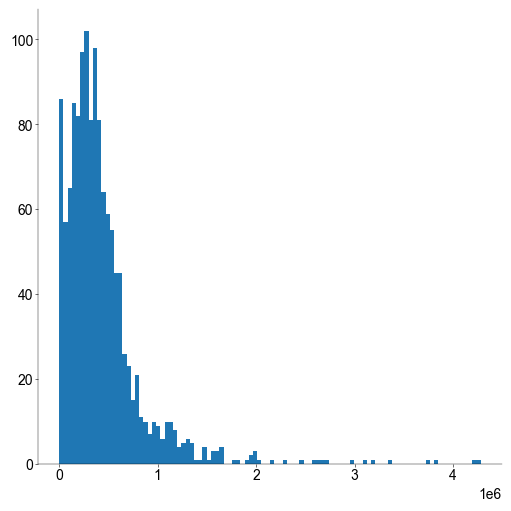

In [119]:
# plot sequencing depth of each cell

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.sum(exonCounts_filtered, axis=1), bins=100)

plt.show()

# 2. Data Normalization and Transformation


In the exercise sheet related to transcriptomic data analysis, we standardized the counts by expressing them as counts per median sequencing depth. Since the data does not consist of unique molecular identifier (UMI) counts, we applied two distinct normalization methods: counts per million (CPM) and reads per kilobase per million (RPKM). Additionally, we applied both log-transformation and square root-transformation to the normalized data in each case.


## 2.1. Counts per million (CPM)

In order to obtain CPM, we have to perform the following calculation for each cell:

$$ CPM = \frac{\text{Read counts mapped to gene}}{\text{Total number of mapped reads}} \times 10^6 $$

For this, the bioinfokit.analys library is used.


In [120]:
# convert exonCounts to dataframe
df = pd.DataFrame(exonCounts_filtered.T, columns=cells, index=genes_filtered)

In [121]:
# Normalization: CPM
nm = norm()
nm.cpm(df)
cpm_df = nm.cpm_norm


# Transformation: Log2 and sqrt transform
cpm_counts = cpm_df.values.T
cpm_counts_log = np.log2(cpm_counts + 1)  # + 1 to avoid log(0)
cpm_counts_sqrt = np.sqrt(cpm_counts)

## 2.3. Reads per kilobase per million (RPKM)

RPKM addresses the issue of variations in gene lengths and sequencing depths:

$$ RPKM = \frac{{\text{Number of uniquely mapped reads to the gene}}}{{\text{gene length in KB} \times \text{Total mapped reads in the sample}}} \times 10^6$$

Again, we use the bioinfokit package to obtain the normalized counts.

In [122]:
# add column with lengths to df
df["length"] = exonLengths_filtered

# Normalization
nm = norm()
nm.rpkm(df=df, gl="length")
rpkm_df = nm.rpkm_norm

# Log and sqrt transform
rpkm_counts = rpkm_df.values.T
rpkm_counts_log = np.log(rpkm_counts + 1)
rpkm_counts_sqrt = np.sqrt(rpkm_counts)

# 3. Two-dimensional Visualization

TSNE and UMAP are dimensionality reduction techniques that create two-dimensional representations of high-dimensional data. TSNE preserves local structure and is visually appealing but computationally expensive. UMAP is faster, scalable, and preserves both local and global structures, but it may not produce visually pleasing representations as effectively as TSNE.

To ensure computational feasibility for dimensionality reduction, we follow the procedure of Kobak and Berens (2019) and perform it on the first fifty principal components.

- TODO: Grid-Search over Parameters

- TODO: Evaluation Schemes

In [123]:
# create a dictionary with the different count types to make it easy to iterate over them

count_dict = {
    "unnormalized": {
        "raw": exonCounts_filtered,
        "log": np.log2(exonCounts_filtered + 1),
        "sqrt": np.sqrt(exonCounts_filtered + 1),
    },
    "cpm": {
        "raw": cpm_counts,
        "log": cpm_counts_log,
        "sqrt": cpm_counts_sqrt,
    },
    "rpkm": {
        "raw": rpkm_counts,
        "log": rpkm_counts_log,
        "sqrt": rpkm_counts_sqrt,
    },
}

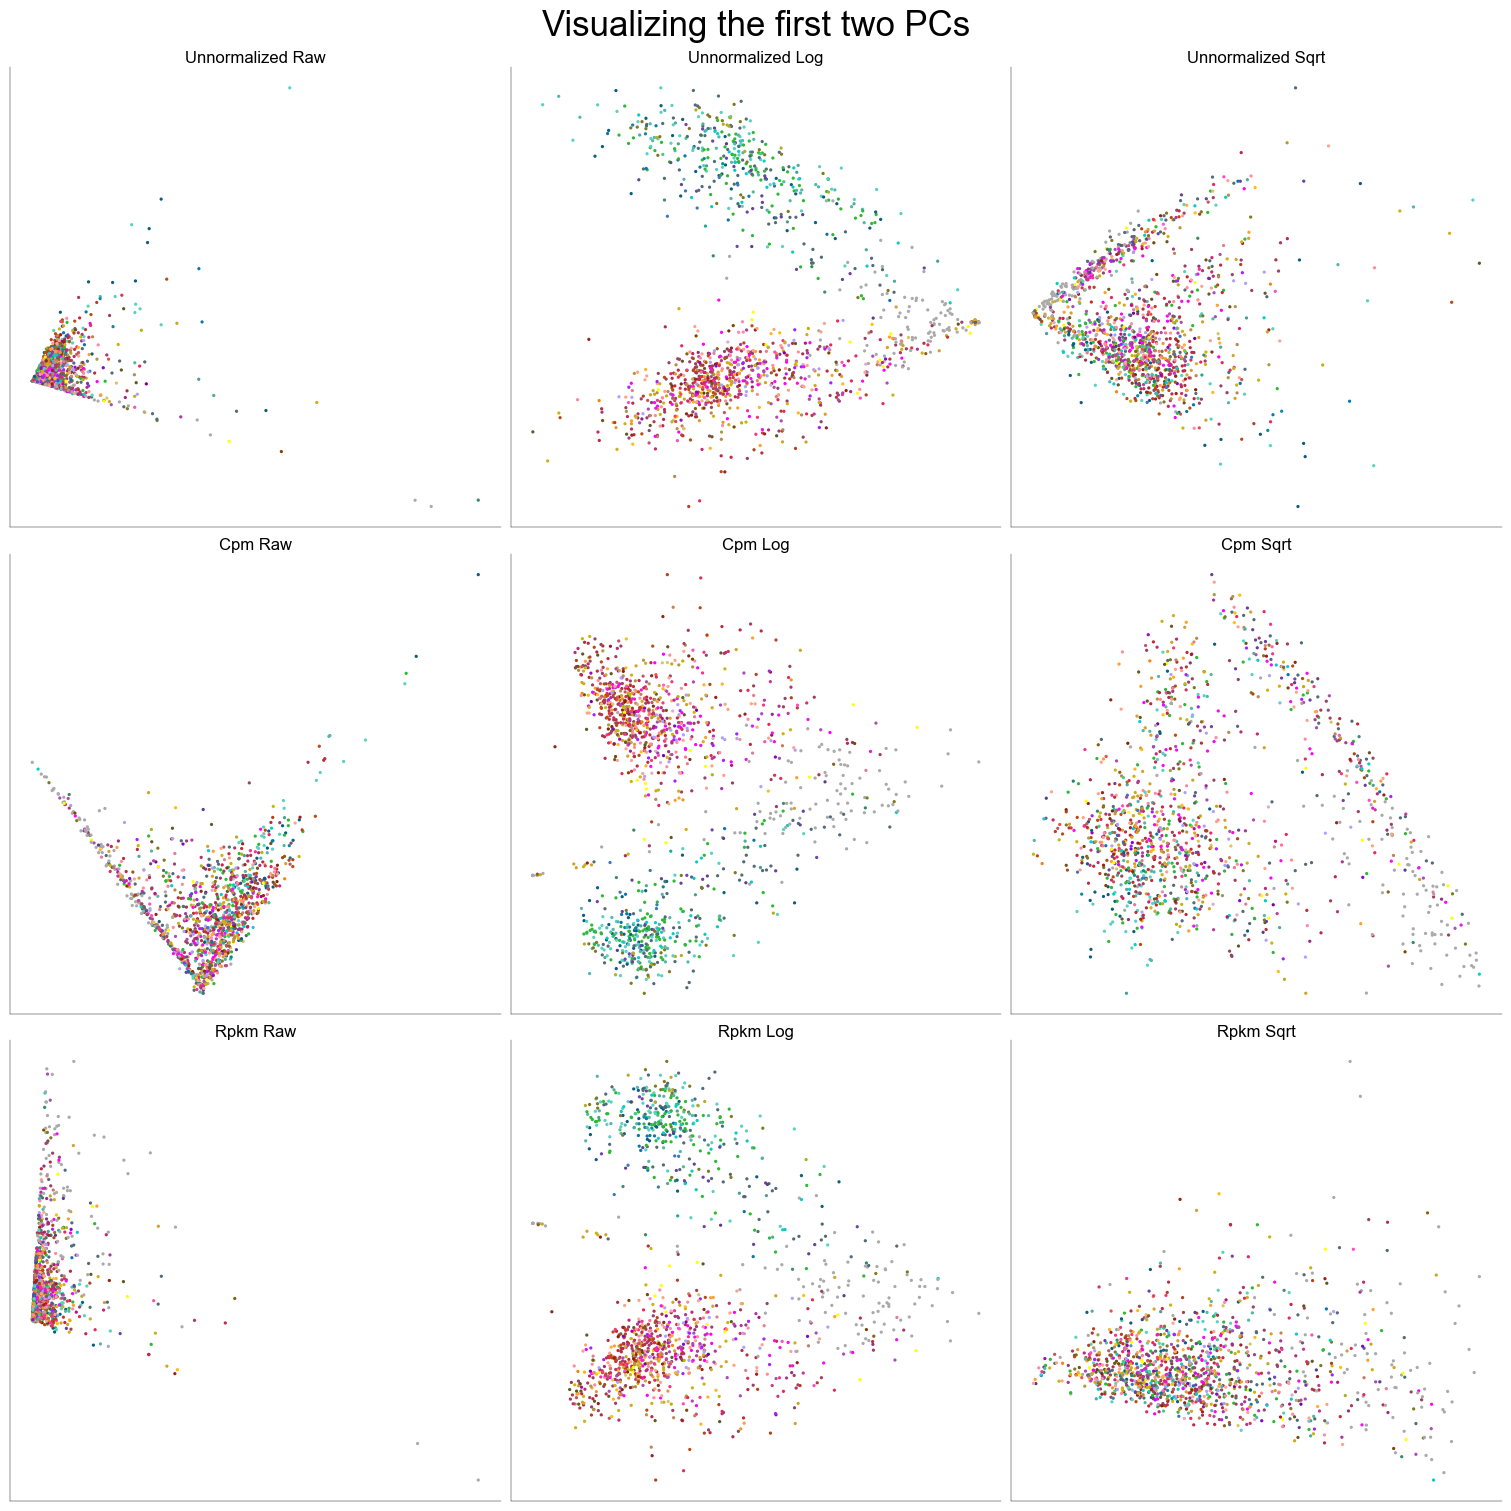

In [124]:
# perform PCA fit
pca = PCA(n_components=50)
pca_results = dict()
for norm_key, sub_dict in count_dict.items():
    pca_results[norm_key] = dict()
    for trans_key, counts in sub_dict.items():
        pca_results[norm_key][trans_key] = pca.fit_transform(counts)

# plot PCA results
plot_2d_vis(pca_results, "Visualizing the first two PCs", cluster_colors)

**Qualitative Analysis:** It appears that PCA alone is insufficient to unveil the clusters. Thus, it becomes necessary, as anticipated, to employ TSNE or UMAP. Presently, there has been no assessment of the various normalization methods' quality.

## 3.1. TSNE

## 3.2. UMAP

# 4. Clustering



## 4.1. Leiden Clustering

## 4.2. Gaussian Mixture Models

## 4.3. Negative Binomial Mixture Model

**Explaination of the Model:**

In [1]:
# TODO: Implement a negative binomial mixture model



# 5. Correlation in between Electrophysiological Features and Genes/PCs

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    